# Height Data

In [1]:
using Distributions
using StatisticalRethinking
using DataFrames
using CSV
using ForwardDiff
using MCMCChains

include("lahmc.jl")
include("run_lahmc.jl")

sample_loop (generic function with 1 method)

In [2]:
howell = CSV.read(sr_datadir("Howell1.csv"), DataFrame)
howell = howell[howell.age .>= 18,:]
howell = sort(howell, :weight)
first(howell, 5)

Row,height,weight,age,male
,Float64,Float64,Float64,Int64
1,143.51,31.0711,18.0,0
2,141.605,31.5246,19.0,1
3,142.24,31.6664,36.0,0
4,136.525,31.8648,65.0,0
5,146.05,31.8648,44.0,0


In [3]:
describe(howell, :all)

Row,variable,mean,std,min,q25,median,q75,max,sum,nunique,nuniqueall,nmissing,nnonmissing,first,last,eltype
,Symbol,Float64,Float64,Real,Float64,Float64,Float64,Real,Real,Nothing,Int64,Int64,Int64,Real,Real,DataType
1,height,154.597,7.74233,136.525,148.59,154.305,160.655,179.07,54418.2,,81,0,352,143.51,163.83,Float64
2,weight,44.9905,6.45671,31.0711,40.2563,44.7922,49.2927,62.9926,15836.7,,289,0,352,31.0711,62.9926,Float64
3,age,41.1385,15.9679,18.0,28.0,39.0,51.0,88.0,14480.8,,77,0,352,18.0,35.0,Float64
4,male,0.46875,0.499733,0,0.0,0.0,1.0,1,165,,2,0,352,0,1,Int64


In [4]:
xbar = mean(howell.weight)
n = nrow(howell)

function U(X)
    a = X[1]
    b = X[2]
    sigma = X[3]
    return -(sum(logpdf(Normal((a + b*(howell[i, :].weight - xbar)), sigma), 
        howell[i, :].height) for i in 1:n) 
        + logpdf(Normal(178, 20), a) + logpdf(LogNormal(0,1), b) + logpdf(Uniform(0, 50), sigma))  
end

function dU(X)
    return ForwardDiff.gradient(U, [X[1], X[2], X[3]])
end

function init_q()
    init_sample = [155, 0.5, 25]
    return init_sample
end

init_q (generic function with 1 method)

In [5]:
n_samples = 1000
n_chains = 50
epsilon = 0.01
K = 4
L = 10
beta = 0.1
n_param = 3

3

In [6]:
lahmc_samples = sample_loop(n_chains, U, dU, init_q, epsilon, L, K, beta, n_param, n_samples)

Dict{Any, Any} with 3 entries:
  :samples    => [155.0 155.0 … 155.0 155.0; 0.5 0.5 … 0.5 0.5; 25.0 25.0 … 25.…
  :trans      => Dict("L1"=>0.996036, "L2"=>0.00136136, "L3"=>0.000940941, "L4"…
  :grad_evals => 503610

In [7]:
hmc_samples = sample_loop(n_chains, U, dU, init_q, epsilon, L, 1, beta, n_param, n_samples)

Dict{Any, Any} with 3 entries:
  :samples    => [155.0 155.0 … 155.0 155.0; 0.5 0.5 … 0.5 0.5; 25.0 25.0 … 25.…
  :trans      => Dict("L1"=>0.996376, "avg_accept"=>0.996376, "F"=>0.00362362)
  :grad_evals => 499500

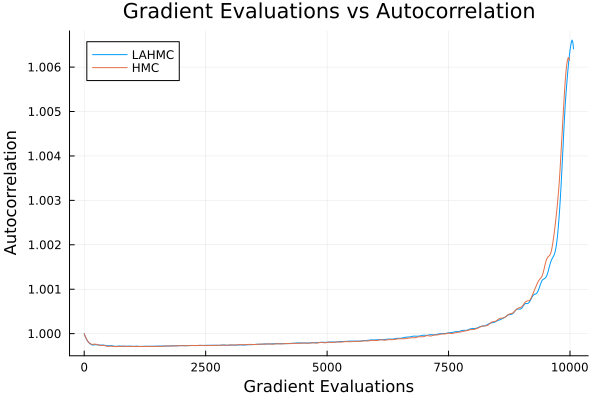

In [8]:
autocorrelation_lahmc = autocorrelation(lahmc_samples[:samples])
autocorrelation_hmc = autocorrelation(hmc_samples[:samples])

gradient_evaluations_lahmc = LinRange(0, lahmc_samples[:grad_evals]/n_chains, length(autocorrelation_lahmc))
gradient_evaluations_hmc = LinRange(0, hmc_samples[:grad_evals]/n_chains, length(autocorrelation_hmc))

plt_lahmc_ac = plot(gradient_evaluations_lahmc, autocorrelation_lahmc, title="Gradient Evaluations vs Autocorrelation", xlabel="Gradient Evaluations", ylabel="Autocorrelation", label="LAHMC")
plt_hmc_ac = plot!(gradient_evaluations_hmc, autocorrelation_hmc, label="HMC")

display(plt_lahmc_ac)

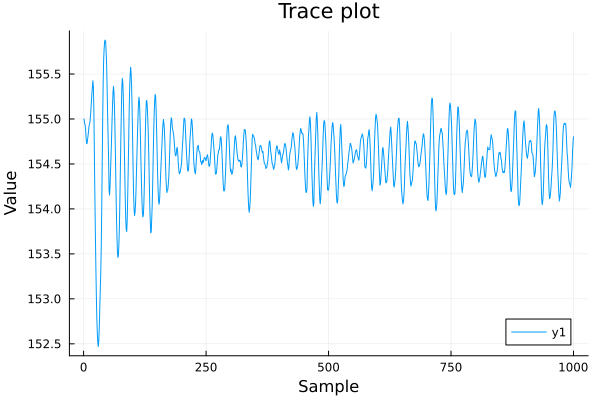

In [9]:
plot(lahmc_samples[:samples][1, 1, :], title="Trace plot", xlabel="Sample", ylabel="Value")

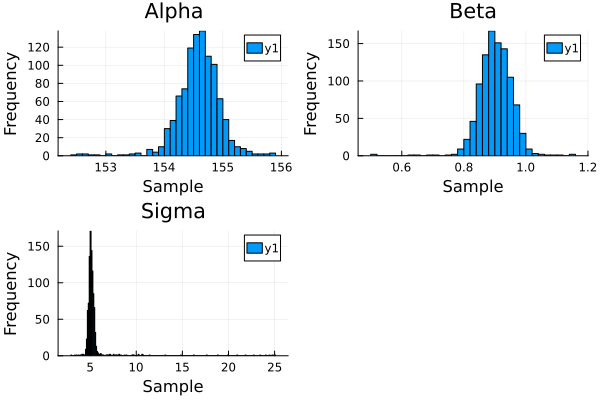

In [10]:
plot(
    histogram(lahmc_samples[:samples][1, 1, :], bin_width=0.01, title="Alpha", xlabel="Sample", ylabel="Frequency"),
    histogram(lahmc_samples[:samples][2, 1, :], bin_width=0.2, title="Beta", xlabel="Sample", ylabel="Frequency"),
    histogram(lahmc_samples[:samples][3, 1, :], bin_width=0.2, title="Sigma", xlabel="Sample", ylabel="Frequency"),
)

In [11]:
lahmc_trans_df = DataFrame(lahmc_samples[:trans])

Row,F,L1,L2,L3,L4,avg_accept
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.000780781,0.996036,0.00136136,0.000940941,0.000880881,0.999219


In [12]:
hmc_trans_df = DataFrame(hmc_samples[:trans])

Row,F,L1,avg_accept
,Float64,Float64,Float64
1,0.00362362,0.996376,0.996376


In [13]:
lahmc_chain = Chains(permutedims(lahmc_samples[:samples], (3,1,2)),[:a, :b, :sigma])
df_lahmc_summary = DataFrame(MCMCChains.summarize(lahmc_chain))
df_lahmc_summary

Row,parameters,mean,std,mcse,ess_bulk,ess_tail,rhat,ess_per_sec
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Missing
1,a,154.604,0.345052,0.00392857,8621.78,5449.83,1.01633,missing
2,b,0.902499,0.0561897,0.000282928,61604.3,6551.33,1.01141,missing
3,sigma,5.44253,2.08187,0.0504878,12404.6,892.165,1.02734,missing


In [14]:
hmc_chain = Chains(permutedims(hmc_samples[:samples], (3,1,2)),[:a, :b, :sigma])
df_hmc_summary = DataFrame(MCMCChains.summarize(hmc_chain))
df_hmc_summary

Row,parameters,mean,std,mcse,ess_bulk,ess_tail,rhat,ess_per_sec
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Missing
1,a,154.605,0.329105,0.00372316,8489.97,7012.41,1.015,missing
2,b,0.902429,0.0557618,0.000283193,61222.9,6850.58,1.01353,missing
3,sigma,5.45484,2.12678,0.0530891,12324.0,875.874,1.03347,missing


In [15]:
df_post = DataFrame(lahmc_samples[:samples][:, 1, :]', :auto)
rename!(df_post,[:a, :b, :sigma])
first(df_post, 5)

Row,a,b,sigma
,Float64,Float64,Float64
1,155.0,0.5,25.0
2,154.951,0.518028,24.9058
3,154.937,0.643286,24.7322
4,154.888,0.827355,24.4513
5,154.797,0.981462,24.034


In [16]:
describe(df_post, :all)

Row,variable,mean,std,min,q25,median,q75,max,sum,nunique,nuniqueall,nmissing,nnonmissing,first,last,eltype
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Nothing,Int64,Int64,Int64,Float64,Float64,DataType
1,a,154.584,0.370548,152.469,154.404,154.601,154.802,155.878,1.54584e5,,1000,0,1000,155.0,154.802,Float64
2,b,0.902408,0.0533748,0.5,0.872038,0.902516,0.935522,1.14749,902.408,,1000,0,1000,0.5,0.887192,Float64
3,sigma,5.43508,2.0671,2.93324,4.95343,5.10888,5.30755,25.0,5435.08,,1000,0,1000,25.0,5.00766,Float64


In [17]:
round.(cov(lahmc_samples[:samples][:, 1, :]'), digits=3)

3×3 Matrix{Float64}:
  0.137  -0.0     0.009
 -0.0     0.003  -0.011
  0.009  -0.011   4.273

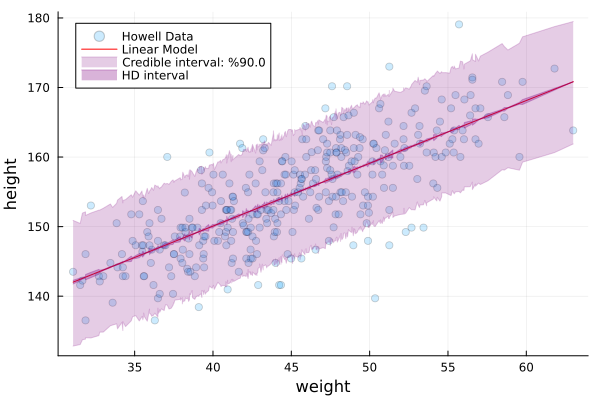

In [18]:
a_mean = mean(lahmc_samples[:samples][1, 1, :])
b_mean = mean(lahmc_samples[:samples][2, 1, :])
sigma_mean = mean(lahmc_samples[:samples][3, 1, :])

pred = [a_mean + b_mean*(x-xbar) for x in howell.weight]

q_alpha = 0.9
quantiles = [quantile(rand(Normal(v, sigma_mean), 1000), [0.5 - q_alpha/2, 0.5 + q_alpha/2]) for v in pred]
q_lower = [q[1] for (q, pred) in zip(quantiles, pred)]
q_upper = [q[2] for (q, pred) in zip(quantiles, pred)]

hdi = [quantile(rand(Normal(v, sigma_mean), 1000), 0.5) for v in pred]
hdi_lower = [min(q[1], pred - (q[1] - pred)) for (q, pred) in zip(hdi, pred)]
hdi_upper = [max(q[1], pred + (pred - q[1])) for (q, pred) in zip(hdi, pred)]

scatter(howell.weight, howell.height; alpha=0.2, xlabel="weight", ylabel="height", label="Howell Data")
plot!(howell.weight, pred, color=:red, alpha=1, label="Linear Model")
plot!(howell.weight, q_lower, color=:purple, alpha=0.2, label=nothing)
plot!(howell.weight, q_upper, fill=q_lower, alpha=0.2, color=:purple, label="Credible interval: %$(q_alpha*100)")
plot!(howell.weight, hdi_lower, color=:purple, alpha=0.3, label=nothing)
plot!(howell.weight, hdi_upper, fill=hdi_lower, alpha=0.3, color=:purple, label="HD interval")